In [1]:
!pip install emoji
!pip install accelerate \
  bitsandbytes \
  transformers==4.36.2 \
  sentencepiece \
  datasets

In [3]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from transformers import BertTokenizer, BertModel
import torch
from collections import Counter
from nltk.tokenize import word_tokenize
import emoji
import numpy as np

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Анализ данных

In [4]:
data = pd.read_csv('train_spam.csv')
data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [6]:
data['text_type'].value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

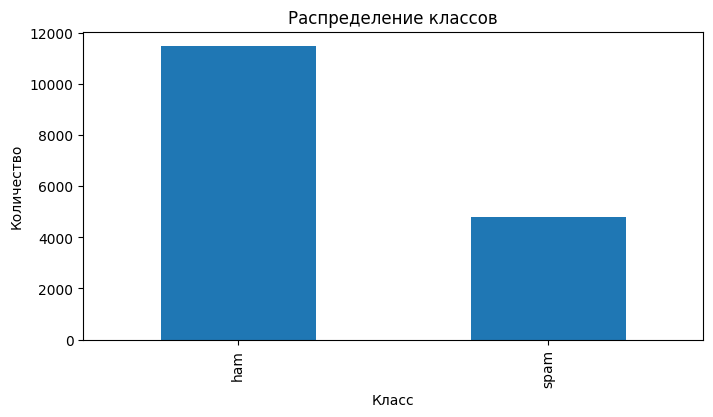

In [7]:
plt.figure(figsize=(8, 4))
data['text_type'].value_counts().plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

<Figure size 1200x600 with 0 Axes>

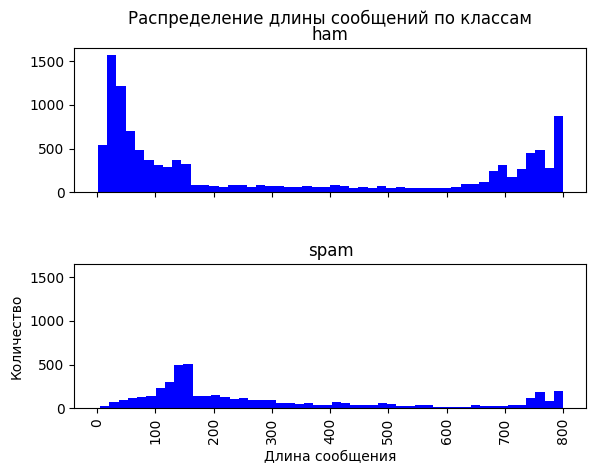

In [9]:
data['message_length'] = data['text'].apply(len)
plt.figure(figsize=(12, 6))
data.hist(column='message_length', by='text_type', bins=50, layout=(2, 1), sharex=True, sharey=True, color='blue')
plt.suptitle('Распределение длины сообщений по классам')
plt.xlabel('Длина сообщения')
plt.ylabel('Количество')
plt.show()

In [11]:
data.head()

,text_type,text,message_length
0,ham,make sure alex knows his birthday is over in f...,86
1,ham,a resume for john lavorato thanks vince i will...,520
2,spam,plzz visit my website moviesgodml to get all m...,126
3,spam,urgent your mobile number has been awarded wit...,139
4,ham,overview of hr associates analyst project per ...,733


# Предобработка данных


In [12]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['msg_len'] = data['text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['text'].apply(lambda x: count_punct(x))

def clean_text(text):
    text = emoji.demojize(text, delimiters=("", " "))
    text = "".join([word.lower() if word not in string.punctuation else ' ' for word in text])
    tokens = re.split('\W+', text)
    text = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords and word.strip()]
    if not text:
        text = ["<empty>"]
    return text

In [13]:
spam_msgs = data[data['text_type'] == "spam"]['text']
tokenizer = nltk.RegexpTokenizer(r'\w+')

def clean_tokenize(text):
    tokens = tokenizer.tokenize(text.lower())
    filter_words = [word for word in tokens if word not in stopwords and len(word) > 1]
    return filter_words

words = []
for msg in spam_msgs:
    words.extend(clean_tokenize(msg))

word_counts = Counter(words)

most_common_words = word_counts.most_common(10)
spam_words_set = set([word for word, count in most_common_words])

def spam_word_percent(text):
    words = word_tokenize(text.lower())
    spam_words_count = sum(1 for word in words if word in spam_words_set)
    total_words_count = len(words)
    if total_words_count > 0:
        return (spam_words_count / total_words_count)
    else:
        return 0.
data['spam_word_percent'] = data['text'].apply(spam_word_percent)

In [14]:
X = data[['text','msg_len', 'punct%', 'spam_word_percent']]
Y = data['text_type']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [ ]:
X_train['text'].values.tolist()[0:32]

In [ ]:
y_train = np.where(Y_train['text_type'] == 'spam', 1, 0)
y_test = np.where(Y_test['text_type'] == 'spam', 1, 0)

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', model_max_length = 512 )
model = BertModel.from_pretrained('bert-base-uncased', torch_dtype=torch.float16, load_in_8bit=True, device_map="cuda:0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [36]:
token = tokenizer("<empty>", padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    outputs = model(**token)
cls_embedding = outputs.last_hidden_state[:, 0, :]
print(cls_embedding.numpy().shape)

(1, 768)


In [ ]:
X_train['text'].values.tolist()

In [ ]:
def bert_vectorize(text):
    cleaned_text = clean_text(text)
    tokens = tokenizer(cleaned_text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens)
    cls_embedding = outputs.last_hidden_state[0,0,:]
    return cls_embedding.numpy()

X_train_bert = [bert_vectorize(text) for text in X_train['text'].values.tolist()]
X_test_bert = [bert_vectorize(text) for text in X_test['text'].values.tolist()]

In [ ]:
X_train_bert = np.array(X_train_bert)
X_test_bert = np.array(X_test_bert)

In [ ]:
feature_train_array = np.array(X_train[['msg_len', 'punct%', 'spam_word_percent']].values)
feature_test_array = np.array(X_test[['msg_len', 'punct%', 'spam_word_percent']].values)

In [ ]:
X_train_vect = np.concatenate([X_train_bert, feature_train_array], axis = 1)
X_test_vect = np.concatenate([X_test_bert, feature_test_array], axis = 1)

# Попробуем разные модели

На подбор оптимальных параметров мне, увы 😭😭😭😭😭, не хватило времени………


## RandomForest с перебором параметров

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensamble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from skelarn.model_selection import GridSearchCV

In [ ]:
rf = RandomForestClassifier()
param = {'n_estimators': [100, 200, 300],
         'max_depth': [10, 20, 30]}
grid_search = GridSearchCV(rf, param_grid=param, cv=5, scoring='roc_auc')
grid_search.fit(X_train_vect, y_train)

print("Лучшая модель:", grid_search.best_params_)
roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test_vect)[:, 1])
print("ROC-AUC Score:", roc_auc)

## LogisticRegression

In [ ]:
model = LogisticRegression()
model.fit(X_train_vect, y_train)
y_pred = model.predict_proba(X_test_vect)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC Score:", roc_auc)

## GradientBoosting


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

X_train = np.array(X_train_vect)
X_test = np.array(X_test_vect)
Y_train = np.array(y_train)
Y_test = np.array(y_test)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')

params = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'eta': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
grid_search.fit(X_train, Y_train)

print("Лучшие параметры:", grid_search.best_params_)
best_model = grid_search.best_estimator_

preds = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(Y_test, preds)

print("ROC-AUC Score for XGBoost with best parameters:", roc_auc)


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

cat_model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=0)

param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=cat_model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train_vect, y_train, eval_set=(X_test_vect, y_test))

print("Лучшие параметры:", grid_search.best_params_)
best_cat_model = grid_search.best_estimator_

cat_preds = best_cat_model.predict_proba(X_test_bert_vect)[:, 1]
roc_auc_cat = roc_auc_score(Y_test, cat_preds)
print("ROC-AUC Score for optimized CatBoost:", roc_auc_cat)


# Лучшая модель
Тут должна быть выбрана лучшая модель, но я не успел, поэтому покажу хотя бы на CatBoost

In [ ]:
test = pd.read_csv('test_spam.csv')
test.head()

In [ ]:
test['spam_word_percent'] = data['text'].apply(spam_word_percent)
test['msg_len'] = test['text'].apply(lambda x: len(x) - x.count(" "))
test['punct%'] = test['text'].apply(lambda x: count_punct(x))
test.head()

In [ ]:
X_test_fin = [bert_vectorize(text) for text in test['text'].values.tolist()]
X_test_fin = np.array(X_test_fin)

In [ ]:
feature_test_fin = np.array(test[['msg_len', 'punct%', 'spam_word_percent']].values)

In [ ]:
X_train_fin = np.concatenate([X_train_vect, X_test_vect])
y_train_fin = np.concatenate([y_train, y_test])
X_test_fin = np.concatenate([X_test_fin, feature_test_fin], axis=1)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.01,
                           depth=10,
                           eval_metric='AUC',
                           random_seed=42,
                           verbose=200)

model.fit(X_train_fin, y_train_fin)
predictions_proba = model.predict_proba(X_test_fin)

In [ ]:
probabilities = predictions_proba[:, 1]

results = pd.DataFrame({
    'text': test['text'],
    'probability_class_1': probabilities
})
results.to_csv('results.csv', index=False)